In [25]:
import pandas as pd
import os

base_dir = "./inputs"
files = os.listdir(base_dir)
files

['sample_submission.csv', 'test.csv', 'train.csv']

In [26]:
# Load the data
train_df = pd.read_csv(os.path.join(base_dir, files[2])).set_index("id")
train_df

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert
...,...,...,...,...,...,...,...,...
18519,3.0,No,7.0,3.0,No,9.0,7.0,Extrovert
18520,1.0,NaN,6.0,7.0,No,6.0,5.0,Extrovert
18521,7.0,Yes,1.0,1.0,Yes,1.0,NaN,Introvert


In [27]:
# Missing values?
missing = train_df.isna().sum()
missing

Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

In [38]:
# train_df[train_df["Stage_fear"].isnull()]
numerical_df = train_df.select_dtypes(include=["number"])
numerical_df

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
id,,,,,
0,0.0,6.0,4.0,15.0,5.0
1,1.0,7.0,3.0,10.0,8.0
2,6.0,1.0,0.0,3.0,0.0
3,3.0,7.0,3.0,11.0,5.0
4,1.0,4.0,4.0,13.0,NaN
...,...,...,...,...,...
18519,3.0,7.0,3.0,9.0,7.0
18520,1.0,6.0,7.0,6.0,5.0
18521,7.0,1.0,1.0,1.0,NaN


In [29]:
categories = train_df.select_dtypes(include=object).columns
non_categories = train_df.select_dtypes(include=["number"]).columns

display(categories)
display(non_categories)

Index(['Stage_fear', 'Drained_after_socializing', 'Personality'], dtype='object')

Index(['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
       'Friends_circle_size', 'Post_frequency'],
      dtype='object')

In [39]:
# Imputation of missing values
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler

def predictive_column_imputer(df):
    df = df.copy()
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    label_encoders = {col: LabelEncoder() for col in cat_cols}

    # Encode categorical columns
    for col in cat_cols:
        non_null_mask = df[col].notnull()
        df.loc[non_null_mask, col] = label_encoders[col].fit_transform(df.loc[non_null_mask, col])
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = df.apply(pd.to_numeric, errors='coerce')

    for column in df.columns:
        if df[column].isnull().sum() > 0:
            print(f"Imputing column: {column}")

            # Split data into training (non-missing) and test (missing)
            not_null_mask = df[column].notnull()
            null_mask = df[column].isnull()

            y_train = df.loc[not_null_mask, column]
            X_train = df.loc[not_null_mask].drop(columns=[column])
            X_test = df.loc[null_mask].drop(columns=[column])

            # Impute only if there's enough data
            if len(X_train) < 10 or len(X_test) == 0:
                print(f"Skipping {column} due to insufficient data")
                continue

            # Scale numerical features
            scaler = StandardScaler()
            X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
            X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

            # Decide model type
            if y_train.dtype.kind in 'iO':  # int or object -> classification
                model = CatBoostClassifier(verbose=0)
            else:
                model = CatBoostRegressor(verbose=0)

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            # Fill missing values
            df.loc[null_mask, column] = y_pred

    # Optionally, reverse label encoding
    for col in cat_cols:
        if df[col].isnull().sum() == 0:
            df[col] = df[col].astype(int)
            df[col] = label_encoders[col].inverse_transform(df[col])

    return df

predictive_column_imputer(train_df)


Imputing column: Time_spent_Alone
Imputing column: Stage_fear
Imputing column: Social_event_attendance
Imputing column: Going_outside
Imputing column: Drained_after_socializing
Imputing column: Friends_circle_size
Imputing column: Post_frequency


,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.000000,No,6.0,4.0,No,15.0,5.000000,Extrovert
1,1.000000,No,7.0,3.0,No,10.0,8.000000,Extrovert
2,6.000000,Yes,1.0,0.0,Yes,3.0,0.000000,Introvert
3,3.000000,No,7.0,3.0,No,11.0,5.000000,Extrovert
4,1.000000,No,4.0,4.0,No,13.0,6.219460,Extrovert
...,...,...,...,...,...,...,...,...
18519,3.000000,No,7.0,3.0,No,9.0,7.000000,Extrovert
18520,1.000000,No,6.0,7.0,No,6.0,5.000000,Extrovert
18521,7.000000,Yes,1.0,1.0,Yes,1.0,1.418785,Introvert


In [25]:
train_df = train_df.dropna()
train_df

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
id,,,,,,,,
0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
7,2.0,No,8.0,3.0,No,4.0,5.0,Extrovert
9,1.0,No,8.0,6.0,No,14.0,9.0,Extrovert
...,...,...,...,...,...,...,...,...
18509,1.0,No,3.0,4.0,No,15.0,4.0,Extrovert
18511,0.0,No,4.0,5.0,No,11.0,4.0,Extrovert
18514,6.0,No,5.0,3.0,No,10.0,4.0,Extrovert


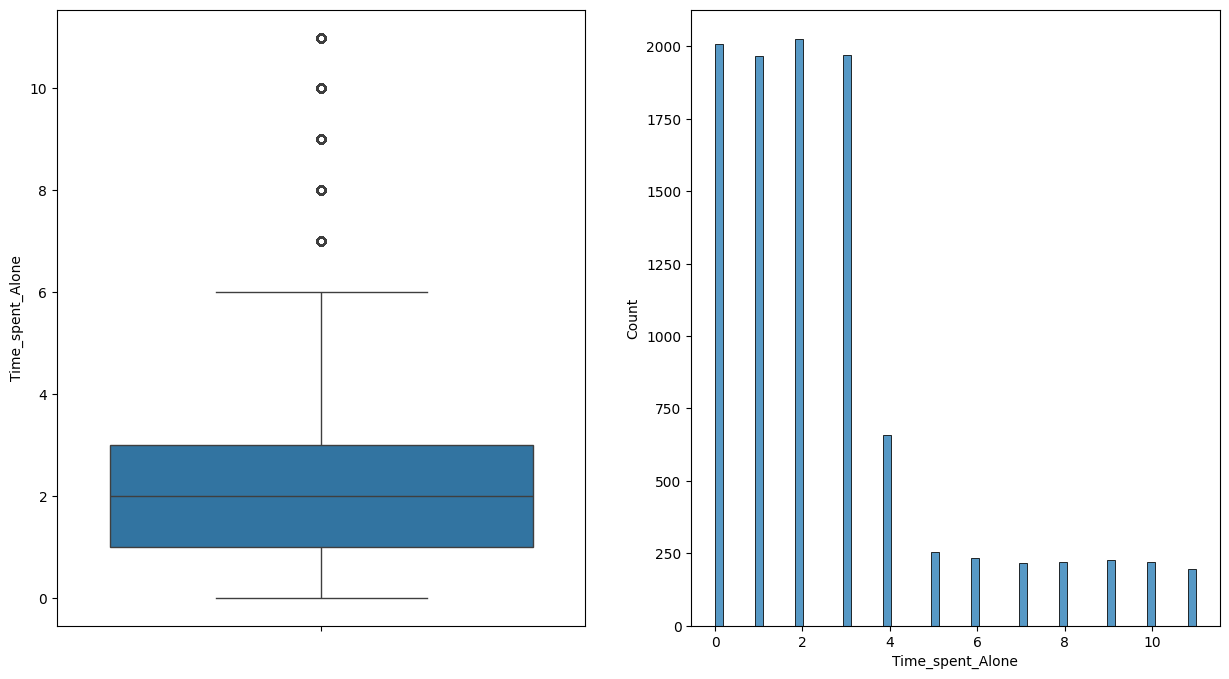

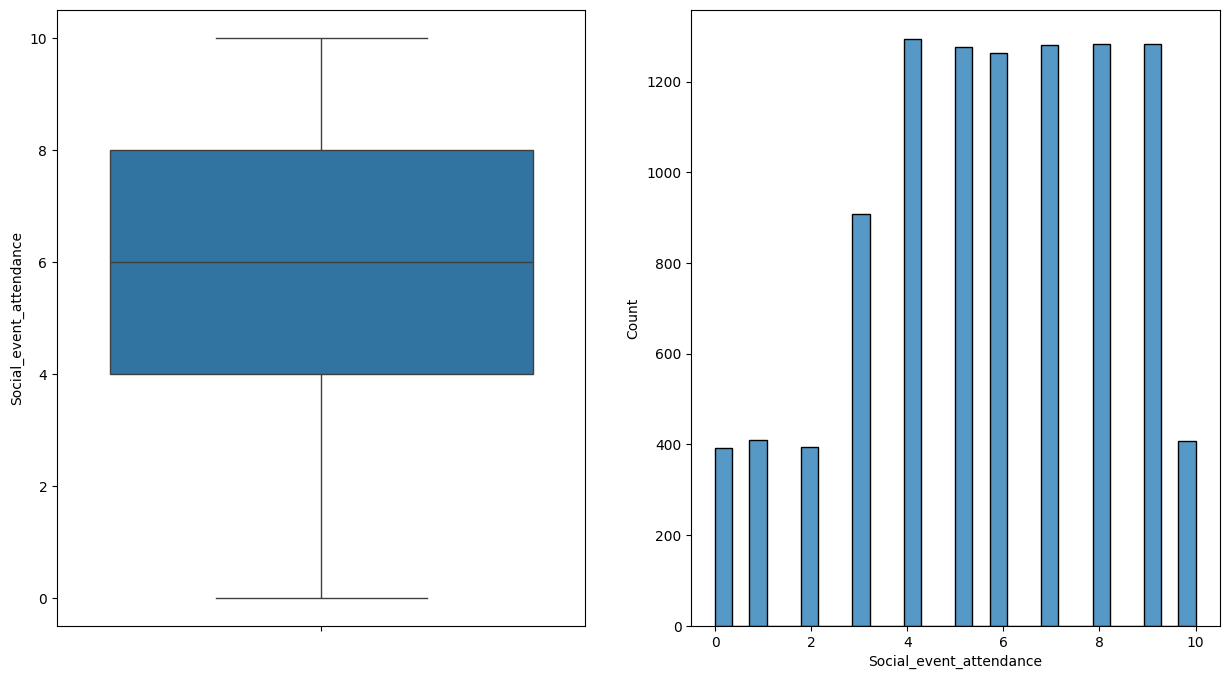

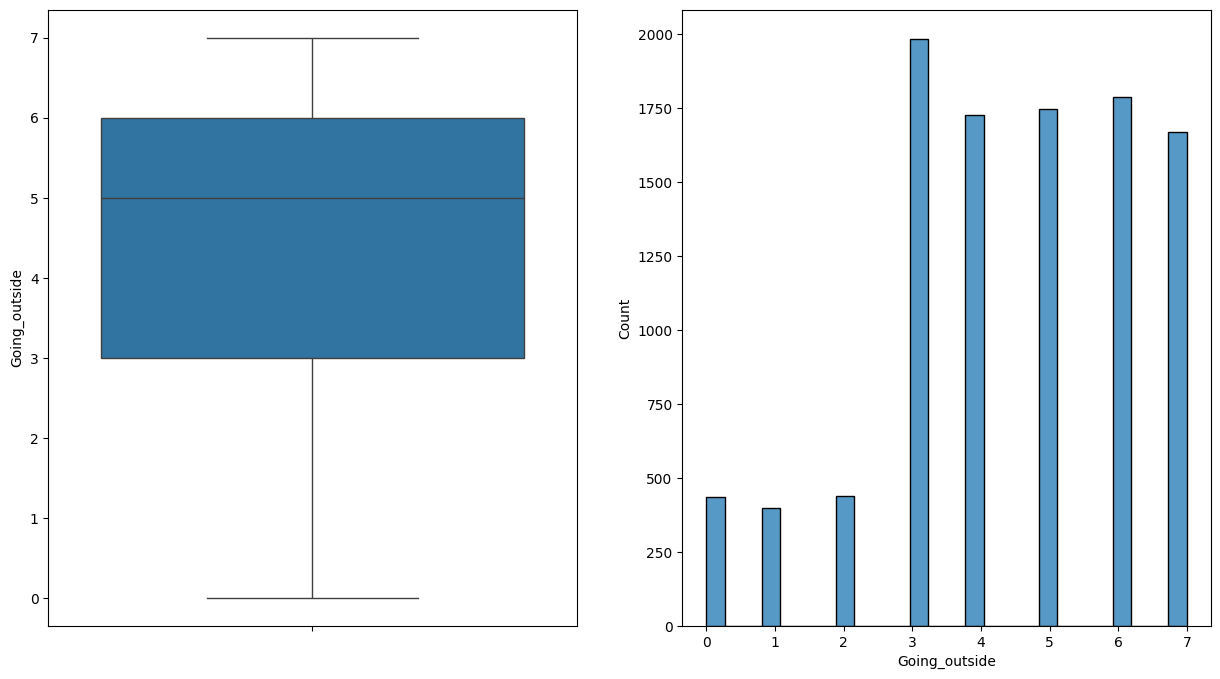

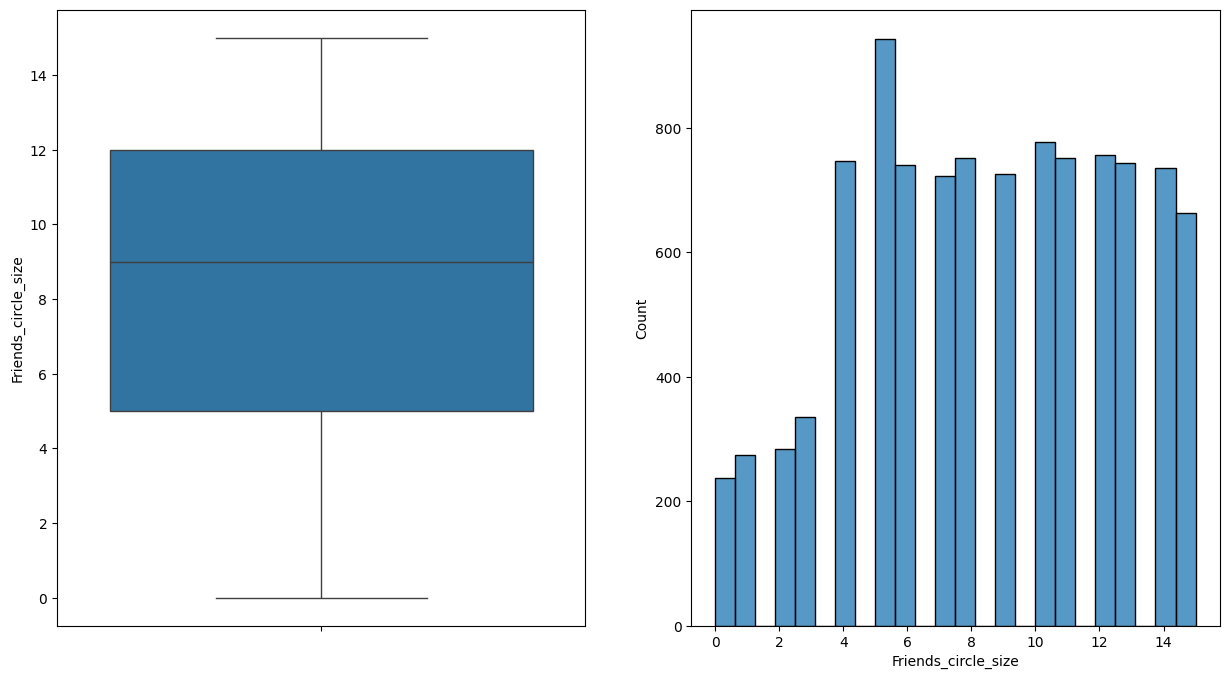

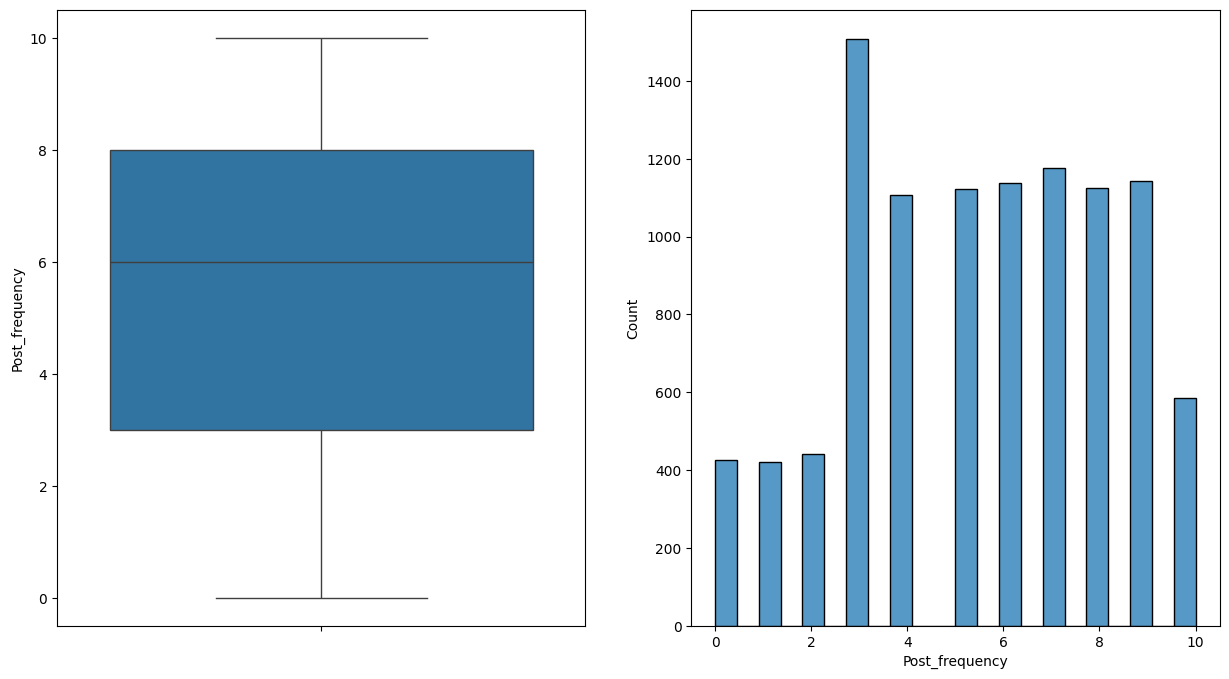

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

for column in non_categories:
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=train_df, y=column, )
    plt.subplot(1, 2, 2)
    sns.histplot(data=train_df, x=column, kde=False)
    plt.show()

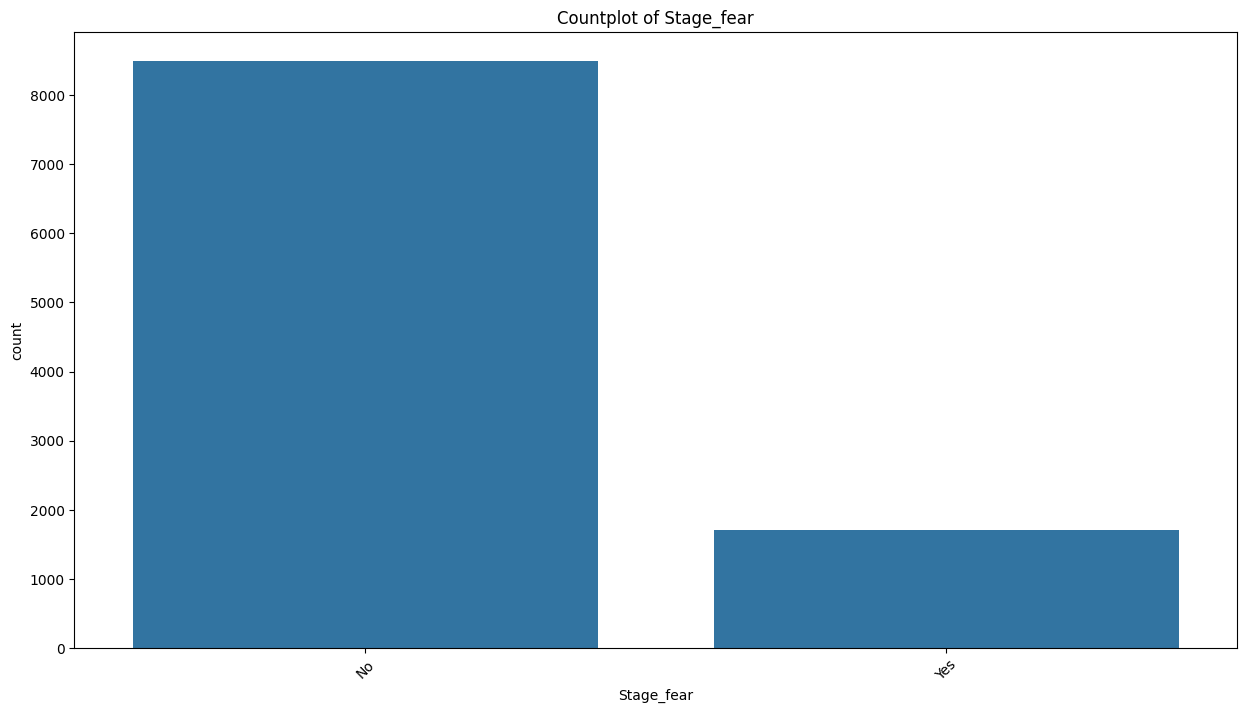

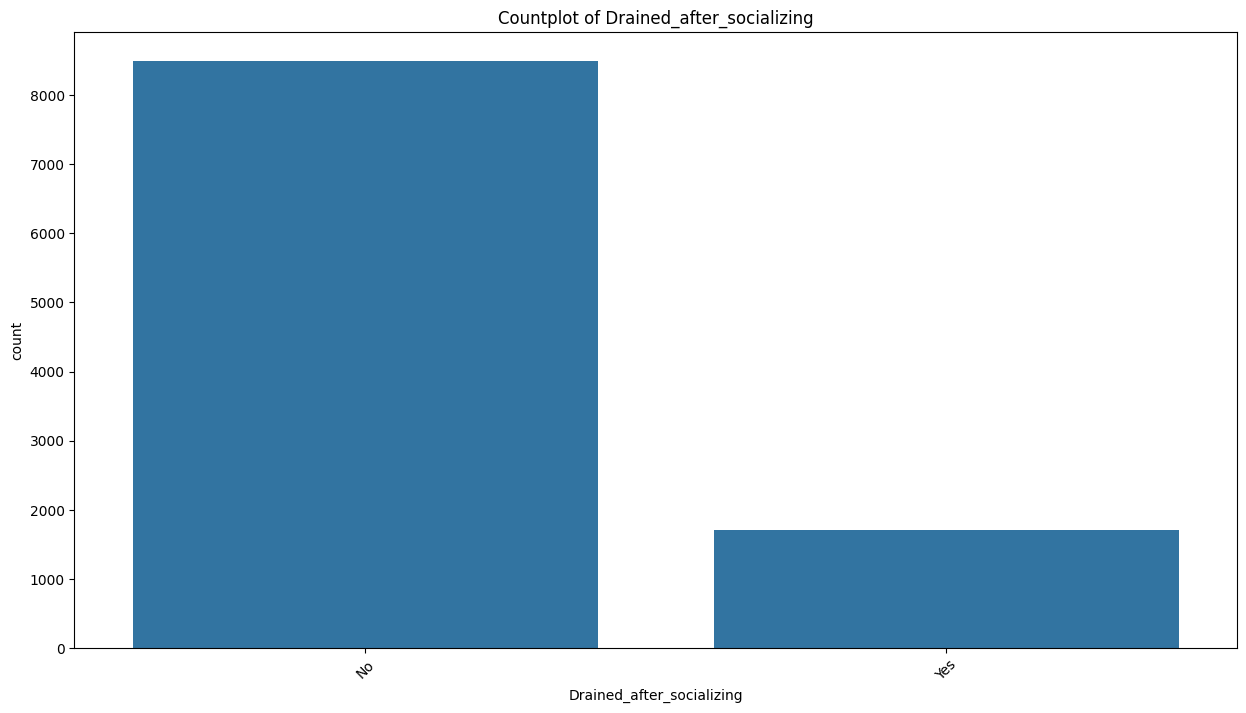

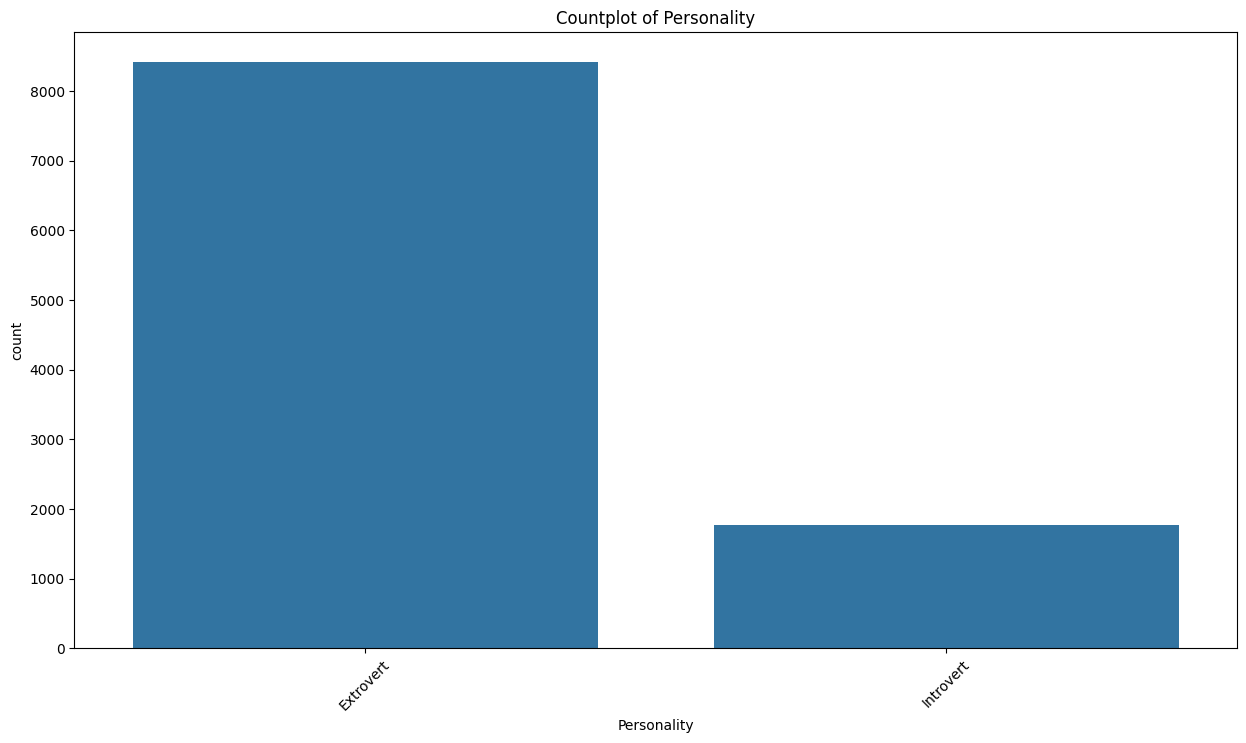

In [30]:
for column in categories:
    plt.figure(figsize=(15, 8))
    sns.countplot(data=train_df, x=column, order=train_df[column].value_counts().index)
    plt.title(f'Countplot of {column}')
    plt.xticks(rotation=45)
    plt.show()

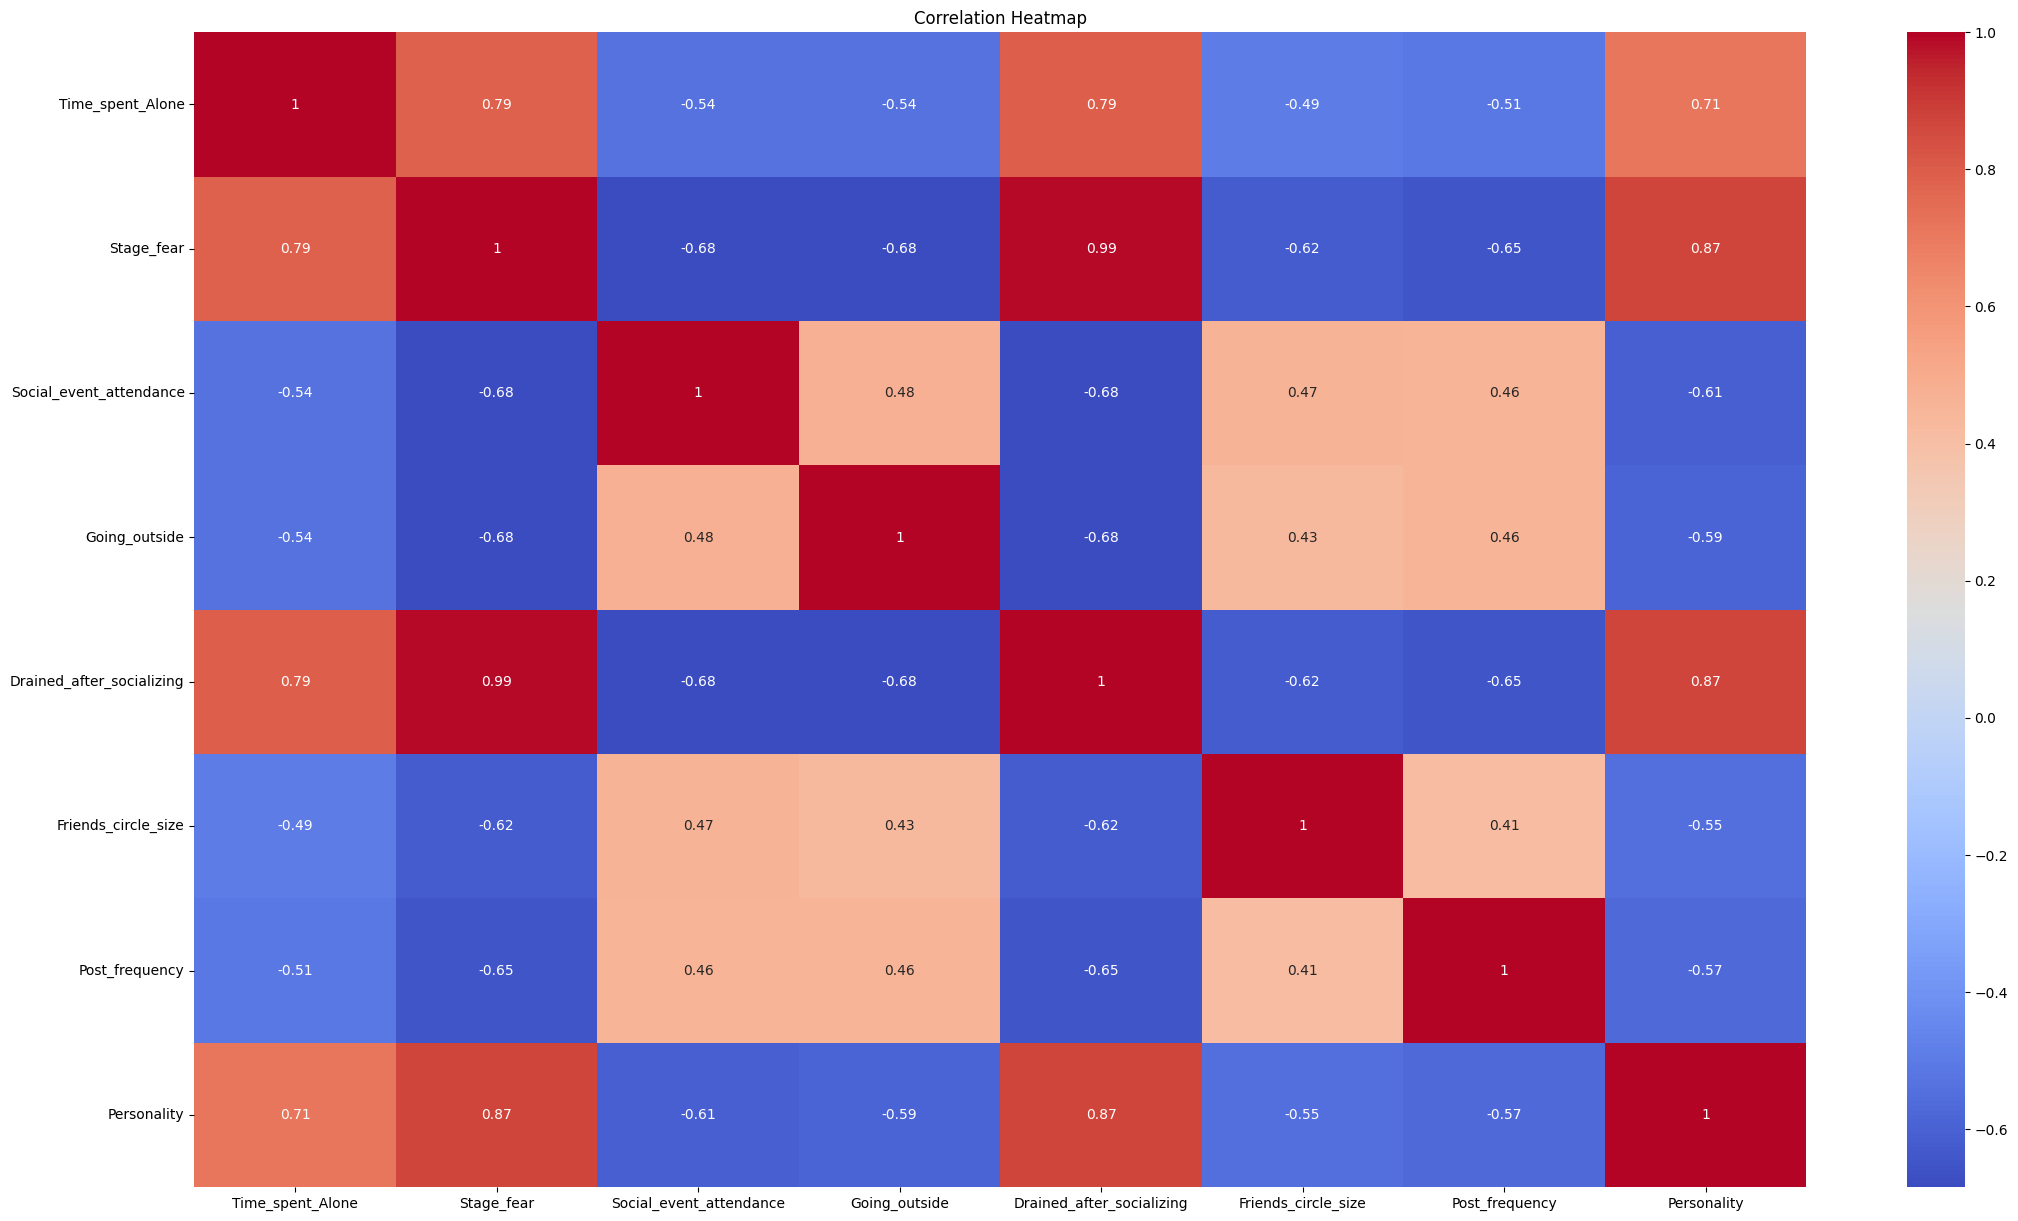

In [32]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

encoder = LabelEncoder()

for column in categories:
    train_df[column] = encoder.fit_transform(train_df[column])

numeric_df = train_df.select_dtypes(include=["number"])
plt.figure(figsize=(26, 15))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Feature - Target Correlation:

Stage_fear                   0.872364
Drained_after_socializing    0.870648
Time_spent_Alone             0.712608
Social_event_attendance     -0.607804
Going_outside               -0.590319
Post_frequency              -0.571306
Friends_circle_size         -0.551907
Name: Personality, dtype: float64


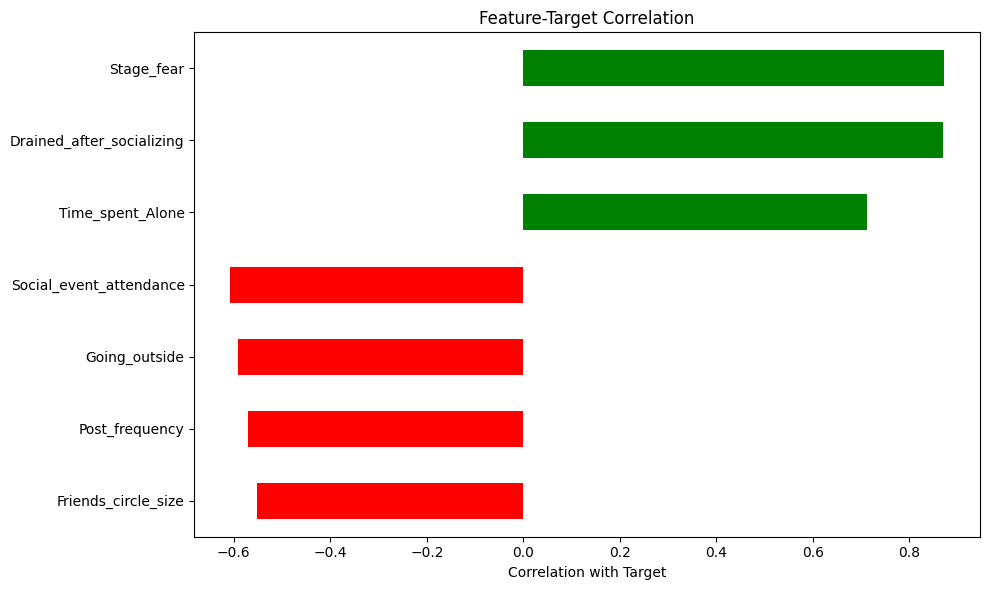

In [33]:
target_col = "Personality"

# 2. Drop rows with missing target values
numeric_df = numeric_df.dropna(subset=[target_col])

# 3. Calculate correlation of all features with the target
correlation_with_target = numeric_df.corr()[target_col].drop(target_col)

# 4. Sort by absolute correlation value (strongest at top)
sorted_corr = correlation_with_target.reindex(correlation_with_target.abs().sort_values(ascending=False).index)

# 5. Display the results
print("Feature - Target Correlation:\n")
print(sorted_corr)

# 6. Optional: Visualize as horizontal bar plot
plt.figure(figsize=(10, 6))
sorted_corr.plot(kind='barh', color=sorted_corr.apply(lambda x: 'green' if x > 0 else 'red'))
plt.xlabel('Correlation with Target')
plt.title('Feature-Target Correlation')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()